# **0. Package Loading (*Must Run*)**

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from library import plot_ecdf, marker_cycle, linestyle_cycle, color_cycle, frexp, search_dir, ensure_path, centered_subplots
from functools import partial
from typing import List, Tuple, Dict, Union, Iterable, Literal, Callable
from matplotlib.ticker import PercentFormatter

import gc
import os
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('error')

%matplotlib inline

In [ ]:
ESSENCE_DATA = 'essence-bent'

In [30]:
ALL_POOLS = [2697765, 2697600, 2697585, 2697647, 2697588]
RISKY = [2697765, 2697600, 2697585, 2697647]

NICK = {2697585: 'E100', 2697600: 'E30', 2697765: 'E5', 2697647: 'B30', 2697588: 'T5'}

class Style:
    C = {"GT": 'red', "BR": 'magenta',  "NE": 'blue',
         "R_NE": 'orange', "I_NE": (.0, .9, .8), "YDay": (.6, .4, .1)}
    L = {"GT": '--', "BR": '-.', "NE": ':',
         "R_NE": '-.', "I_NE": '-', "YDay": '--'}
    M = {"GT": 'o', "BR": '^', "NE": 'v',
         "R_NE": '*', "I_NE": 'x', "YDay": 's'}

In [31]:
TOKEN_X = {2697585: 'ETH', 2697600: 'ETH', 2697765: 'ETH', 2697647: 'USDC', 2697588: 'USDT'}
TOKEN_Y = {2697585: 'USDC', 2697600: 'USDC', 2697765: 'USDC', 2697647: 'BTC', 2697588: 'USDC'}

GRID_KWARGS = dict(visible=True, lw=.7, ls=":", alpha=.5)
BOX_KWARGS = dict(notch=True, showfliers=False, showmeans=True, meanprops={'markeredgecolor': 'magenta', 'marker': 'x'})

NCOL = 2

# **1. Data Loading (*Must Run*)**

Loaded ```ANALYSIS``` is a dictionary where each pool ID maps to a dictionary containing the following keys:
- ```'daily_tvl'```: A list of daily total value locked by players.
- ```'daily_invest'```: A list of daily investment amount tuple of (total, player).
- ```'daily_fee'```: A list of daily fee amount tuple of (total, player).
- ```'ranges'```: A list of number of ranges with fees.
- ```'ranges_jit_only'```: A list of number of ranges with fees only collected by non-players.
- ```'utils'```: A dictionary keyed by strategy ('NE', ...) and valued by their corresponding utilities.
- ```'gt_olaps'```: A dictionary keyed by strategy ('NE', ...) and valued by their corresponding overlaps with GT.
- ```'rois'```: A dictionary keyed by strategy ('NE', ...) and valued by their corresponding ROIs.
- ```'gaps'```: A dictionary keyed by strategy ('NE', ...) and valued by their corresponding normalized optimality gaps.
- ```'pos_count'```: A dictionary keyed by strategy ('NE', 'GT', 'BR') and valued by the number of liquidity positions.
- ```'pos_span'```: A dictionary keyed by strategy ('NE', 'GT', 'BR') and valued by the total span of liquidity positions.
- ```'compare'```: A list of tuples (GT, NE) where each tuple is a sample that demonstrates the difference between GT and NE strategies. 

In [32]:
cooked_files = [file for file in os.listdir(ESSENCE_DATA) if file.endswith('pkl')]

ANALYSIS = {}
for file in cooked_files:
    try:
        pid = int(file[:-4])
        if pid in ALL_POOLS:
            with open(f'{ESSENCE_DATA}/{file}', 'rb') as f:
                ANALYSIS[pid] = pickle.load(f)
    except ValueError:
        continue

PIDS = sorted(ANALYSIS.keys(), key=lambda x: NICK[x])

# 2. LaTeX Tabular Report

In [33]:
TAB_HEAD = f'\\begin{{tabular}}{{c|c|*{{{len(PIDS)}}}{{c}}}}\n'
TAB_HEAD += '    \\toprule\n    \\multicolumn{2}{c}{} & ' + ' & '.join(NICK[pid] for pid in PIDS) + ' \\\\\n    \\midrule\n'
TAB_TAIL = '    \\bottomrule\n\\end{tabular}\n'

STATS  = {
    'Q1': lambda x: np.quantile(x, .25),
    'Q2(Med)': lambda x: np.median(x),
    'Q3': lambda x: np.quantile(x,.75),
    'Mean': lambda x: np.mean(x),
    'Std': lambda x: np.std(x),
}

MACRO = {
    'GT': '\\gt',
    'BR': '\\br',
    'NE': '\\ne',
    'I_NE': '\\ine',
    'R_NE': '\\rne',
    'YDay': '\\yday',
    'NE_all': '\\nea'
}

In [34]:
all_latex_exports = {}

In [35]:
def LaTeX_num(num: float, fmt: str='.2f', mode: Literal["percent", "exp", "int"]=None):
    if mode == 'percent':
        return f"${num * 100:{fmt}} \\%$"
    elif mode == 'exp':
        mm, me = frexp(num)
        return f"${mm:.2f}\\times 10^{{{me:d}}}$"
    elif mode == 'int':
        return f"${int(num):d}$"

    return f"${num:{fmt}}$"

def LaTeX_stats(arr: Iterable[float], fmt: str='.2f', mode: Literal["percent", "exp", "int"]=None):
    if mode == 'percent':
        return f"${np.mean(arr) * 100:{fmt}} \\pm {np.std(arr) * 100:{fmt}} \\%$"
    elif mode == 'exp':
        mm, me = frexp(np.mean(arr))
        sm = np.std(arr) / (10**me)
        return f"$({mm:.2f}\\pm {sm:.2f})\\times 10^{{{me:d}}}$"
    elif mode == 'int':
        return f"${int(np.mean(arr)):d} \\pm {int(np.std(arr)):d}$"

    return f"${np.mean(arr):{fmt}} \\pm {np.std(arr):{fmt}}$"

def multirows(name: str, data_arrs: List[List[float]], funcs: Dict[str, Callable[[List[float]], float]], 
              fmt: str='.2f', mode: Literal["percent", "exp", "int"]=None, indent=0):
    latex_code = f'{"":{indent}}\\multirow[c]{{{len(funcs)}}}{{*}}{{{MACRO[name]}}}\n'
    for fname, func in funcs.items():
        latex_code += f'{"":{indent}} & {fname} & '
        latex_code += ' & '.join(LaTeX_num(func(arr), fmt=fmt, mode=mode) for arr in data_arrs) + ' \\\\\n'
    return latex_code

## *LaTeX - General*

In [36]:
metadata = []
pool_df = pd.read_csv('pairs.csv', index_col='pair_id')

for pid in PIDS:
    row = pool_df.loc[pid]
    csv_name = f"{search_dir(pid)}/{pid}-Total.csv"
    file = np.memmap(csv_name)
    num_entries = np.sum(file == ord('\n')) - 2
    del file
    metadata.append((NICK[pid], row['token0_symbol'], row['token1_symbol'], 
                     f"{row['fee']/100:g}\\%", num_entries, row['address']))

del pool_df

meta_df = pd.DataFrame(metadata, columns=['Nickname', 'Token X', 'Token Y', 'Fee Rate', '\\# Events', 'Address'])
all_latex_exports['Metadata'] = meta_df.style.hide(level=0).to_latex(column_format="*{6}{c}", hrules=True)
meta_df

,Nickname,Token X,Token Y,Fee Rate,\# Events,Address
0,B30,WBTC,USDC,0.3\%,43172,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35
1,E100,USDC,WETH,1\%,9126,0x7bea39867e4169dbe237d55c8242a8f2fcdcc387
2,E30,USDC,WETH,0.3\%,247477,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8
3,E5,USDC,WETH,0.05\%,1428340,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
4,T5,USDC,USDT,0.05\%,20697,0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf


In [37]:
basic_info = []
for pid in PIDS:
    tvl = ANALYSIS[pid]['daily_tvl']
    total_budget, player_budget = np.transpose(ANALYSIS[pid]['daily_invest'])
    total_fee, player_fee = np.transpose([x for x in ANALYSIS[pid]['daily_fee'] if x[0] > 0])
    
    budget_percent = LaTeX_stats(player_budget / total_budget, mode='percent')
    fee_percent = LaTeX_stats(player_fee / total_fee, mode='percent')
    
    range_count, bad_range_count = sum(ANALYSIS[pid]['ranges']), sum(ANALYSIS[pid]['ranges_jit_only'])
    range_count_str = f"{bad_range_count}/{range_count}"
    
    if bad_range_count > 0:
        budget_percent = f"\\textcolor{{orange}}{{{budget_percent}}}"
        fee_percent = f"\\textcolor{{orange}}{{{fee_percent}}}"
        range_count_str = f"\\textcolor{{orange}}{{{bad_range_count}}}/{range_count}"
    
    basic_info.append((NICK[pid], LaTeX_stats(tvl, mode='exp'), budget_percent, fee_percent, range_count_str))

basic_df = pd.DataFrame(basic_info, columns=['Nickname', 'Total Value Locked (TVL, \\$)', 'Budget Percentage', 
                                             'Fee Percentage', 'Uncovered/Ranges'])
all_latex_exports['Basic Info'] = basic_df.style.hide(level=0).to_latex(column_format="*{5}{c}", hrules=True)
basic_df

,Nickname,"Total Value Locked (TVL, \$)",Budget Percentage,Fee Percentage,Uncovered/Ranges
0,B30,$(1.50\pm 0.26)\times 10^{7}$,$93.54 \pm 3.73 \%$,$88.25 \pm 16.17 \%$,0/1271
1,E100,$(1.72\pm 0.31)\times 10^{6}$,\textcolor{orange}{$89.35 \pm 5.79 \%$},\textcolor{orange}{$34.44 \pm 9.06 \%$},\textcolor{orange}{390}/833
2,E30,$(7.49\pm 1.87)\times 10^{7}$,$85.57 \pm 7.73 \%$,$93.68 \pm 12.38 \%$,0/1493
3,E5,$(1.35\pm 0.20)\times 10^{8}$,$78.08 \pm 4.49 \%$,$65.22 \pm 17.73 \%$,0/9452
4,T5,$(6.35\pm 1.79)\times 10^{6}$,$97.61 \pm 5.72 \%$,$96.94 \pm 9.89 \%$,0/609


## *LaTeX - Overlap, Utility and ROI Report*

In [38]:
def generate_tabular(strategies: List[str], 
                     key: Literal["gt_olaps", "utils", "rois", "gaps"], 
                     fmt: str='.2f', 
                     mode: Literal["percent", "exp", "int"]=None):
    df_stats, tabrows = [], []

    for strategy in strategies:
        data = [ANALYSIS[pid][key][strategy] for pid in PIDS]
        for stat in STATS.values():
            df_stats.append([stat(ANALYSIS[pid][key][strategy]) for pid in PIDS])
        tabrows.append(multirows(strategy, data, STATS, fmt, mode, indent=4))

    index = [(strategy, stat) for strategy in strategies for stat in STATS.keys()]
    df = pd.DataFrame(df_stats, columns=[NICK[i] for i in PIDS], index=list(np.transpose(index))) 
    return TAB_HEAD + '    \\hline\n'.join(tabrows) + TAB_TAIL, df

In [39]:
STRATEGIES_OLAP = ['BR', 'NE', 'I_NE', 'R_NE', 'YDay']
STRATEGIES_UTIL = ['GT', 'BR', 'NE', 'I_NE', 'R_NE', 'NE_all']
STRATEGIES_GAP = ['GT', 'NE', 'I_NE', 'R_NE']

all_latex_exports['GT Overlap'], overlap_df = generate_tabular(STRATEGIES_OLAP, 'gt_olaps', fmt='.2f', mode='percent')
all_latex_exports['Utility'], utility_df = generate_tabular(STRATEGIES_UTIL, 'utils', mode='int')
all_latex_exports['ROI'], roi_df = generate_tabular(STRATEGIES_UTIL, 'rois', fmt='.3f', mode='percent')
all_latex_exports['NOG'], nog_df = generate_tabular(STRATEGIES_GAP, 'gaps', fmt='.3f', mode='percent')

## *LaTeX - Export*

In [40]:
ensure_path('tabletex')

with open('tabletex/table.tex', 'w') as table:
    table.write("\\documentclass{article}\n\n\\usepackage[margin=1in]{geometry}\n")
    table.write("\\usepackage{amsmath,multirow,booktabs,xcolor}\n")
    for strategy, macro in MACRO.items():
        strategy = strategy.replace('_', '\\_')
        table.write('\\def' + f"{macro}{{{strategy}}}\n")

    table.write("\n\\begin{document}\n\\centering\\small\n\n")
    for name, tabular in all_latex_exports.items():
        table.write(f"\\section*{{{name}}}\n\n{tabular}\n\n")

    table.write("\\end{document}\n\n")

_ = gc.collect()

# 3. Boxplots

In [41]:
def reject_outliers(data, qlo, qhi):
    lo, hi = np.quantile(data, [qlo, qhi])
    return [d for d in data if lo <= d <= hi]

def pdf_all(axs:List[plt.Axes], 
        metric:Literal["gt_olaps", "utils", "rois", "gaps"], 
        pool_ids:List[int], 
        strategies:List[Literal["NE", "BR", "I_NE", "R_NE", "YDay", "GT", "NE_all"]], 
        yaxis_format:Literal["percent", "sci"]=None, 
        y_decimals:int=0,
        shape:Literal["box", "violin"]="violin",
        align_strategy:Union[bool, list, tuple]=False, 
        align_pool:bool=False, 
        quantiles:Tuple[float, float]=(0., 1.), 
        title:Union[bool, Literal["NE", "BR", "I_NE", "R_NE", "YDay", "GT", "NE_all"]]=True,
        title_fmt:str=''):
    if isinstance(align_strategy, bool):
        aligned = strategies
    elif isinstance(align_strategy, (list, tuple)):
        aligned = set(align_strategy) & set(strategies)
        
    ymins, ymaxs = [], []
    for pid, ax in zip(pool_ids, axs):
        if yaxis_format == "percent":
            ax.yaxis.set_major_formatter(PercentFormatter(xmax=1., decimals=y_decimals))
        elif yaxis_format == "sci":
            ax.ticklabel_format(axis='y', scilimits=(0, 0))

        ax.grid(**GRID_KWARGS)
        if title is True:
            ax.set_title(f"{NICK[pid]}")
        elif isinstance(title, str):
            base = "NE" if metric == "gt_olaps" else "GT"
            avg_diff = np.mean(ANALYSIS[pid][metric][title]) - np.mean(ANALYSIS[pid][metric][base])
            ax.set_title(f"{NICK[pid]} ({avg_diff:{title_fmt}})")
            
        data = [ANALYSIS[pid][metric][s] for s in strategies]
        if shape == "box":
            ax.boxplot(data, labels=strategies, **BOX_KWARGS)
        elif shape == "violin":
            x = np.arange(1, len(strategies)+1)
            ax.violinplot([reject_outliers(d, *quantiles) for d in data], widths=.95)
            ax.scatter(x, [np.mean(d) for d in data], marker='x', color='magenta')
            ax.scatter(x, [np.median(d) for d in data], marker='_', color='orange')
            ax.set_xticks(x)
            ax.set_xticklabels(strategies)
        
        mean, q1, q3, inf, sup = [np.array([f(ANALYSIS[pid][metric][s]) for s in aligned]) 
                                    for f in [np.mean, partial(np.quantile, q=.25), partial(np.quantile, q=.75), 
                                            np.min, np.max]]
        qd = q3 - q1
        qmin, qmax = min(q1 - qd*2), max(q3 + qd*2)
        mmin, mmax = min(mean - qd), max(mean + qd)
        gmin, gmax = min(inf- qd*.05) , max(sup + qd*.05)
        ymins.append(max(gmin, min(qmin, mmin)))
        ymaxs.append(min(gmax, max(qmax, mmax)))
        
    if align_pool:
        for ax in axs:
            ax.set_ylim(min(ymins), max(ymaxs))
    elif align_strategy:
        for ax, ymin, ymax in zip(axs, ymins, ymaxs):
            ax.set_ylim(ymin, ymax)

In [42]:
ensure_path(ESSENCE_DATA)

## Paper Main

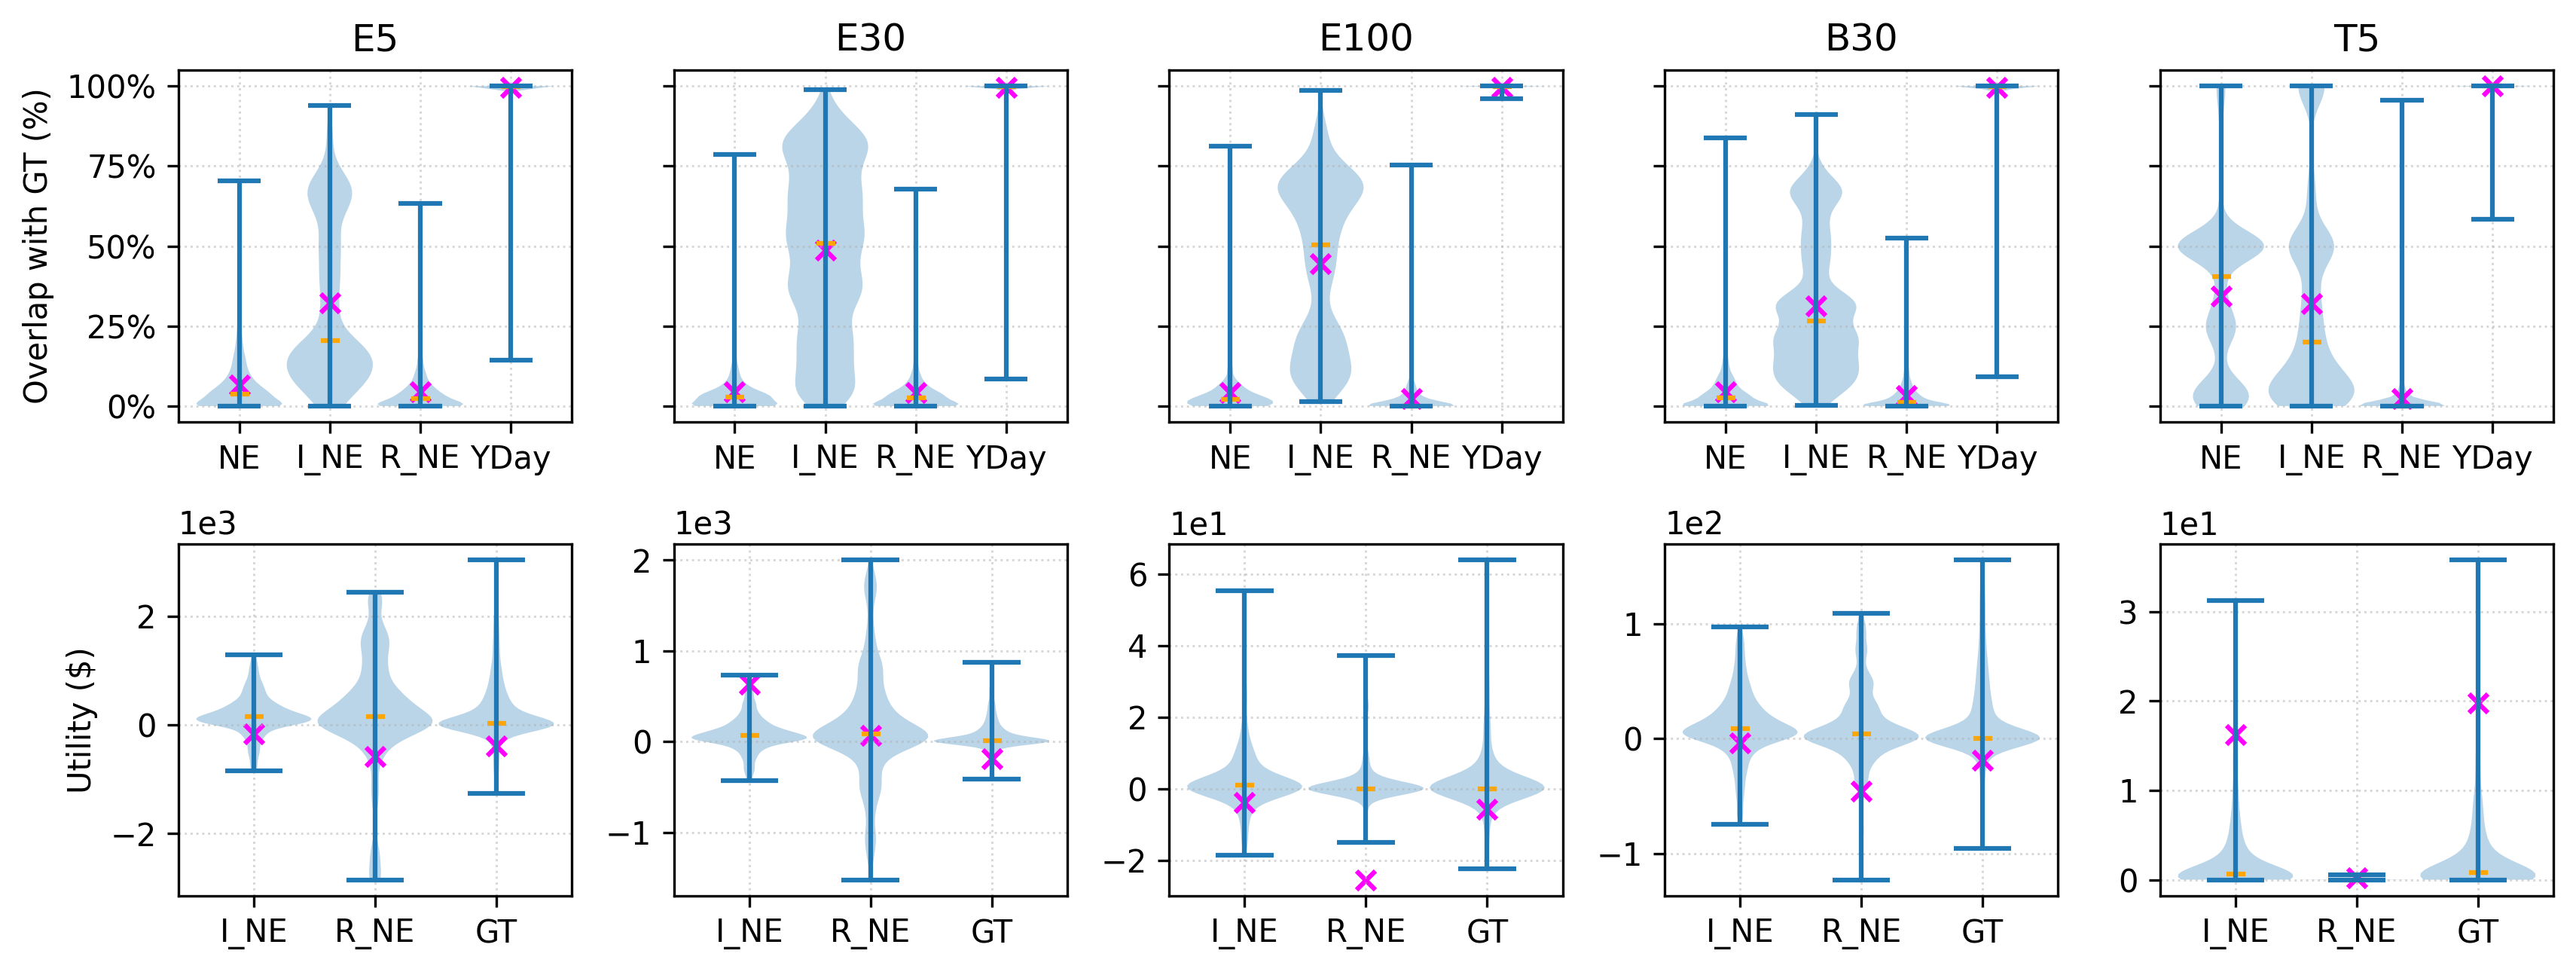

In [43]:
fig, axm = plt.subplots(ncols=len(ALL_POOLS), nrows=2, figsize=(len(ALL_POOLS)*2.3, 2*2.2), dpi=300, squeeze=False)
pdf_all(axm[0, :], "gt_olaps", ALL_POOLS, ['NE', 'I_NE', 'R_NE', 'YDay'], title=True, yaxis_format='percent')
pdf_all(axm[1, :], "utils", ALL_POOLS, ['I_NE', 'R_NE', 'GT'], title=False, yaxis_format='sci', quantiles=[.1, .9])
for ax in axm[0, 1:]:
    ax.set_yticklabels([])
axm[0, 0].set_ylabel("Overlap with GT (%)")
axm[1, 0].set_ylabel("Utility ($)")
fig.tight_layout()
fig.savefig(f'{ESSENCE_DATA}/main-olap-util.jpg', dpi=300)
plt.show()
_ = gc.collect()

## ROI and Gap

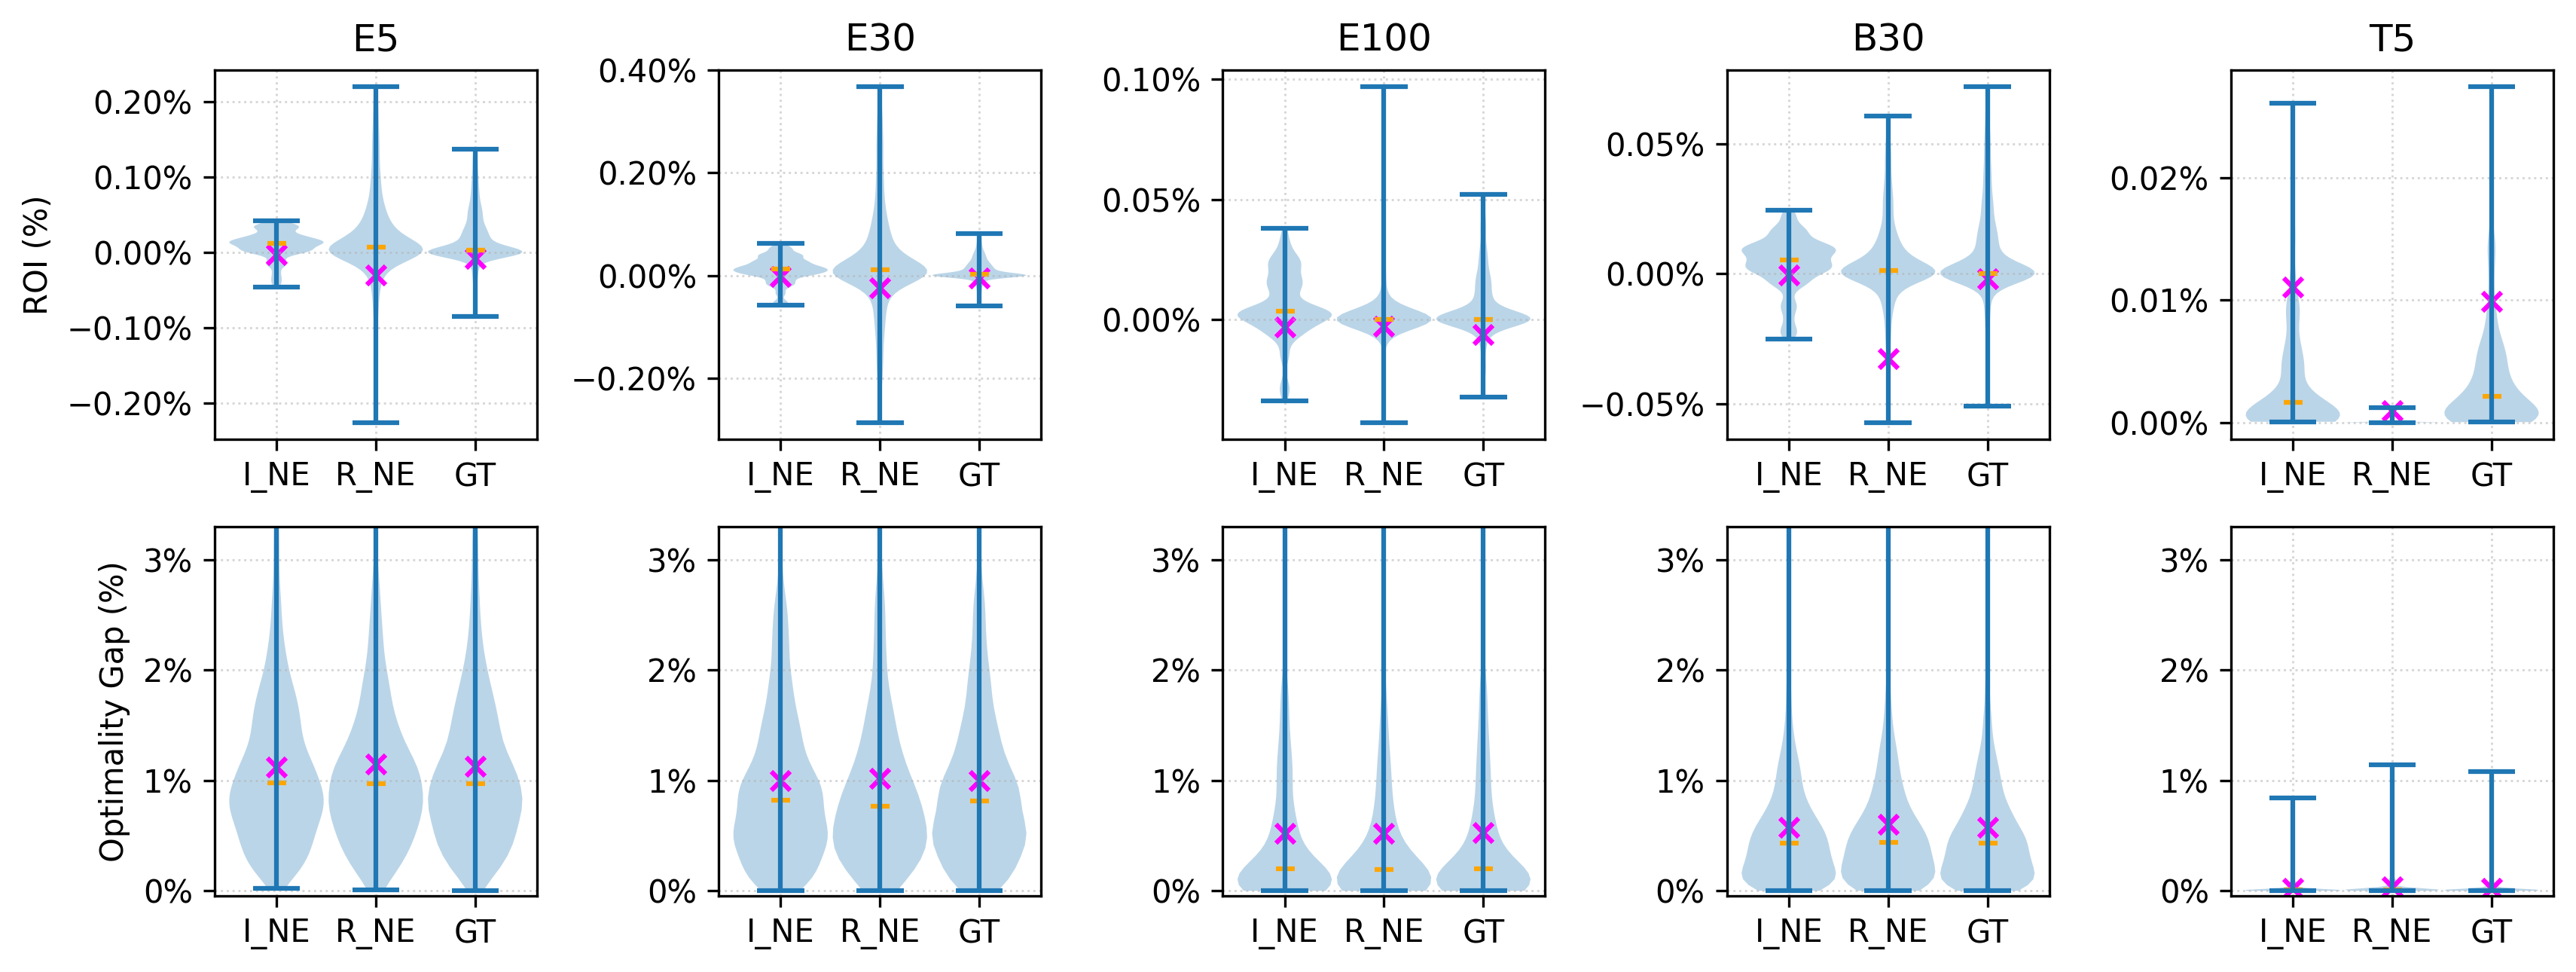

In [44]:
fig, axm = plt.subplots(ncols=len(ALL_POOLS), nrows=2, figsize=(len(ALL_POOLS)*2.3, 2*2.2), dpi=300, squeeze=False)
pdf_all(axm[0, :], "rois", ALL_POOLS, ['I_NE', 'R_NE', 'GT'], title=True, yaxis_format='percent', quantiles=[.1, .9], 
        y_decimals=2)
pdf_all(axm[1, :], "gaps", ALL_POOLS, ['I_NE', 'R_NE', 'GT'], title=False, yaxis_format='percent', 
        y_decimals=0, align_pool=True)
axm[0, 0].set_ylabel("ROI (%)")
axm[1, 0].set_ylabel("Optimality Gap (%)")
fig.tight_layout()
fig.savefig(f'{ESSENCE_DATA}/main-roi-gap.jpg', dpi=300)
plt.show()
_ = gc.collect()

# 4. Low-Level GT-NE Comparison

## Overlap CDF of All Pools

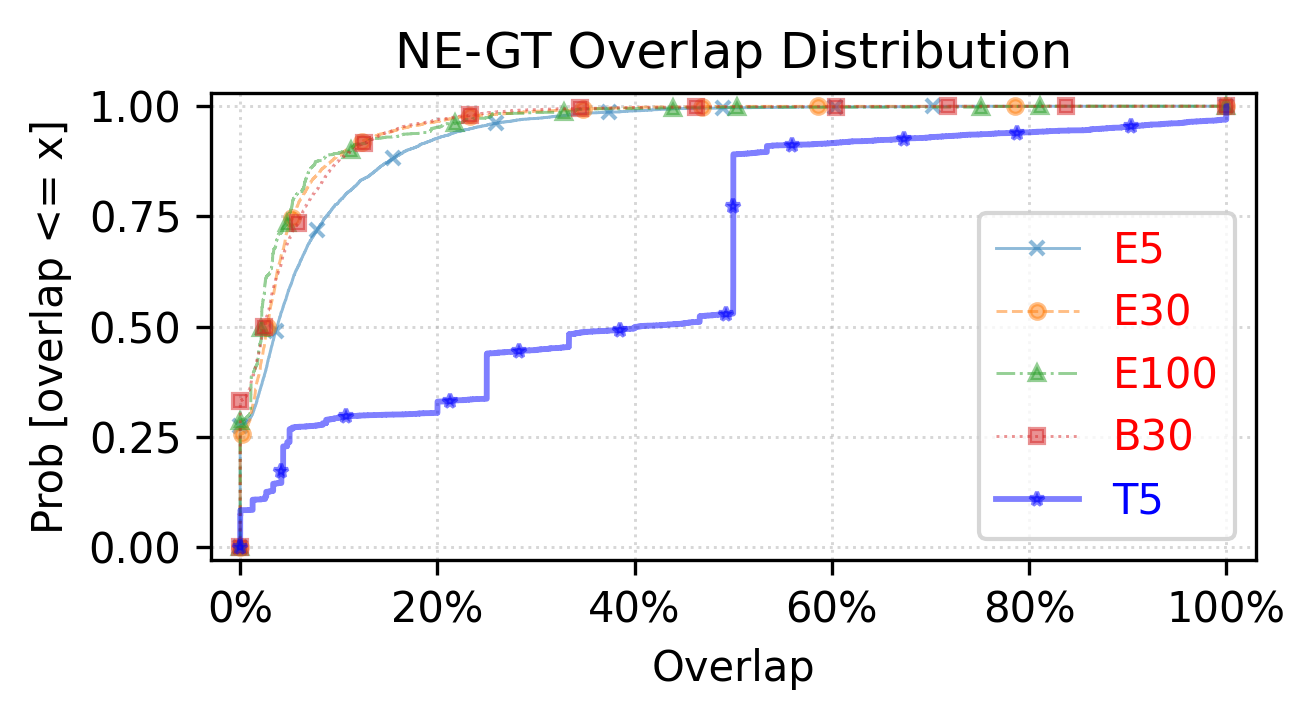

In [45]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4.4, 2.5), dpi=300, squeeze=True)

mc, lc, cc = marker_cycle(), linestyle_cycle(), color_cycle()
for pid in ALL_POOLS:
    kwargs = dict(lw=.7, color=next(cc)) if pid in RISKY else dict(lw=1.4, color='blue')
    plot_ecdf(ANALYSIS[pid]['gt_olaps']["NE"], ax, start=0, end=1, percentage=True, stats=False, label=NICK[pid], 
              ls=next(lc), marker=next(mc), markersize=3.5, markevery=.1, alpha=.5, **kwargs)

ax.legend(loc='lower right')
leg = ax.get_legend()
for pid, text in zip(ALL_POOLS, leg.get_texts()):
    text.set_color('blue' if pid == 2697588 else 'red')

ax.set_title(f'NE-GT Overlap Distribution')
ax.set_xlabel(f'Overlap')
ax.set_ylabel('Prob [overlap <= x]')
ax.set_xlim(-.03, 1.03)
ax.set_ylim(-.03, 1.03)
ax.grid(**GRID_KWARGS)
fig.tight_layout()
fig.savefig(f'{ESSENCE_DATA}/low-olap-cdf.jpg')
# fig.set_size_inches(6.5, 2.5)
# fig.savefig(f'{ESSENCE_DATA}/low-olap-cdf-wide.jpg')
plt.show()
_ = gc.collect()

## Qualitative Comparison

In [46]:
def plot_qualitative(pid, left_expand=1.01, right_expand=1.01):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4.4, 2.5), dpi=150, squeeze=True)
    ax.ticklabel_format(axis='both', scilimits=[0, 0])
    gt, ne = random.choice(ANALYSIS[pid]['compare'])
    width_gt = [gt.T[i+1] - gt.T[i] for i in range(len(gt))]
    width_ne = [ne.T[i+1] - ne.T[i] for i in range(len(ne))]
    ax.set_title(f'Actions in Pool {NICK[pid]}')
    ax.bar(gt.T[:-1], gt.V, width=width_gt, align='edge', ec='k', alpha=.3, label='GT', color=Style.C["GT"])
    ax.bar(ne.T[:-1], ne.V, width=width_ne, align='edge', ec='k', alpha=.3, label='NE', color=Style.C["NE"])
    ax.set_xlim([max(ne.T[0], gt.T[0]) / left_expand, min(ne.T[-1], gt.T[-1]) * right_expand])
    ax.set_xlabel(fr'Pool Price (Delta {TOKEN_Y[pid]} / Delta {TOKEN_X[pid]})')
    ax.set_ylabel(fr'Liquidity $\sqrt{{ {TOKEN_Y[pid]} \cdot \mathrm{{ {TOKEN_X[pid]}}}}}$')
    ax.grid(**GRID_KWARGS)
    ax.legend()
    fig.tight_layout()
    fig.savefig(f'{ESSENCE_DATA}/low-{pid}-histcomp.jpg')
    plt.show()
    _ = gc.collect()

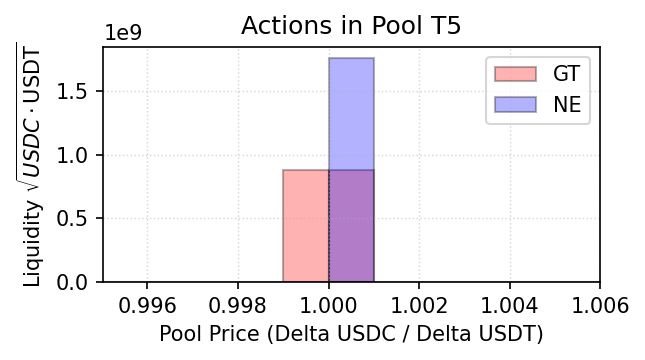

In [47]:
random.seed(1312)
plot_qualitative(2697588, left_expand=1.005, right_expand=1.005)

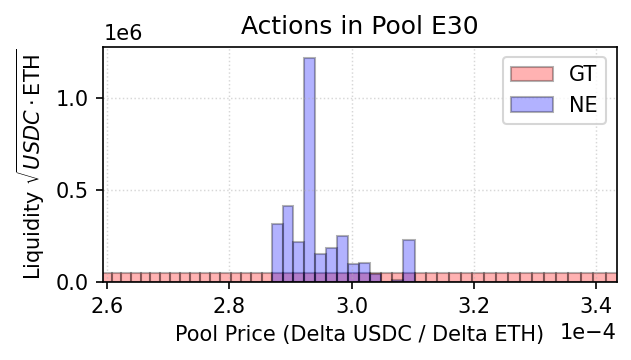

In [48]:
random.seed(1316)
plot_qualitative(2697600, left_expand=1.1, right_expand=1.1)

## Price Span and Count

In [49]:
def plot_price_span_count(pid):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7, 2.2), dpi=300, squeeze=True)
    ax = axs[0]
    ax.set_title(f'CDF of Position Count')
    for key, pcount in ANALYSIS[pid]["pos_count"].items():
        plot_ecdf(pcount, ax, stats=False, end=max(pcount), label=key, lw=.7, color=Style.C[key], marker=Style.M[key], 
                  markersize=3.5, markevery=.1)

    ax.set_xlabel(f'Number of Positions in {NICK[pid]}')
    
    ax = axs[1]
    ax.set_title(r'CDF of Price Span ($q_{max}/q_{min}$)')
    xmax = 0
    caps = {key: np.quantile(pspan, .9) * 2 for key, pspan in ANALYSIS[pid]["pos_span"].items()}
    maxcap = max(caps.values())
    for key, pspan in ANALYSIS[pid]["pos_span"].items():
        pspan = np.minimum(pspan, caps[key]*2)
        plot_ecdf(pspan, ax, stats=False, end=maxcap, label=key, lw=.7, color=Style.C[key], marker=Style.M[key], 
                  markersize=3.5, markevery=.1, alpha=.5)
        xmax = max(xmax, np.quantile(pspan, .9) + 1)
    ax.set_xlim(.95, xmax)
    ax.set_xlabel(f'Price Span in {NICK[pid]}')
    for ax in axs:
        ax.grid(**GRID_KWARGS)
        ax.legend()
        
    fig.tight_layout()
    fig.savefig(f'{ESSENCE_DATA}/low-{pid}-price-span-count.jpg')
    plt.show()
    _ = gc.collect()


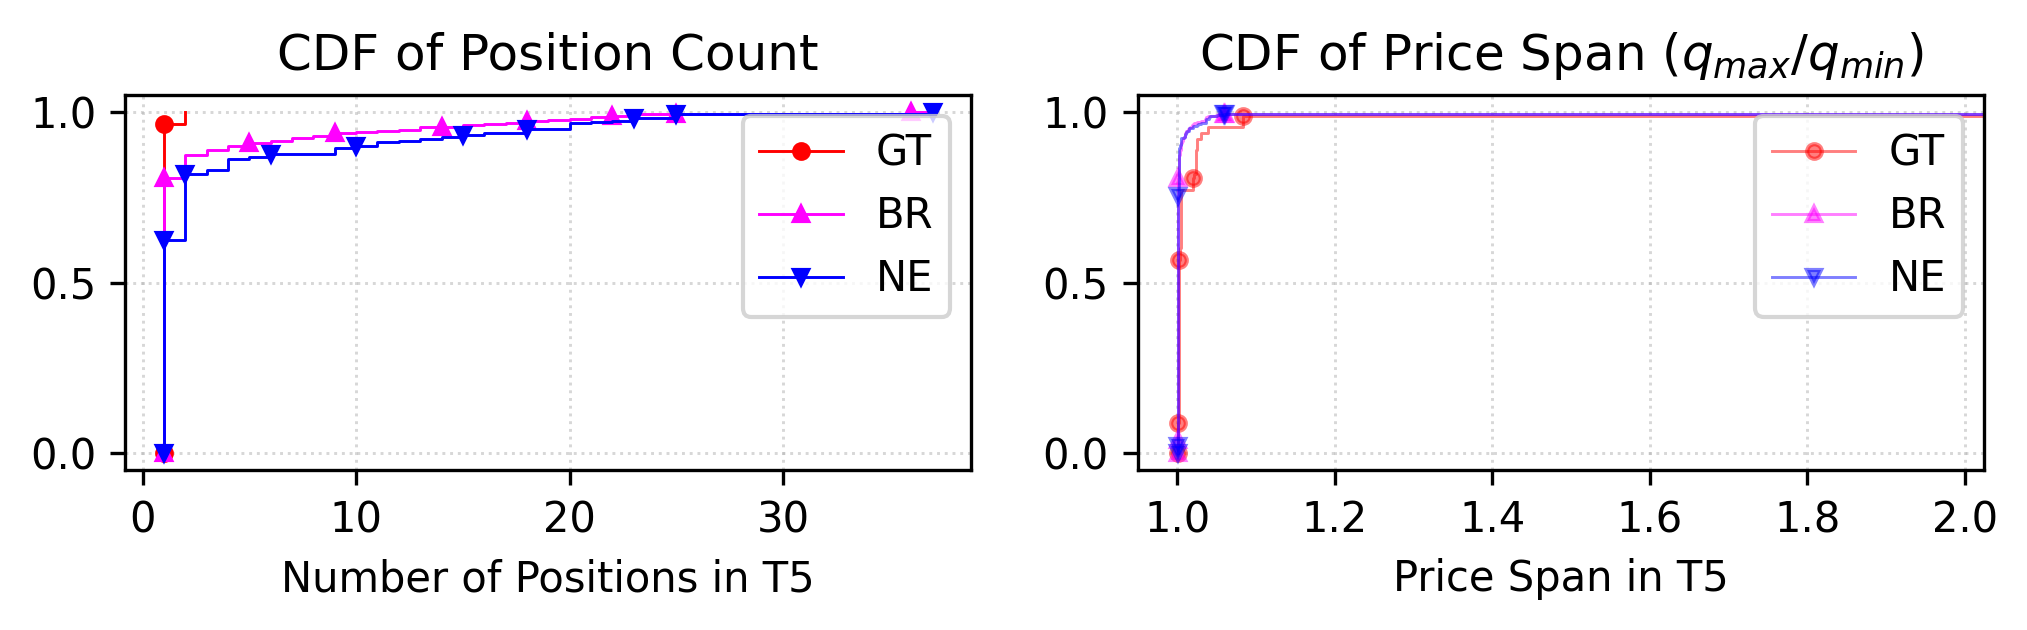

In [50]:
plot_price_span_count(2697588)

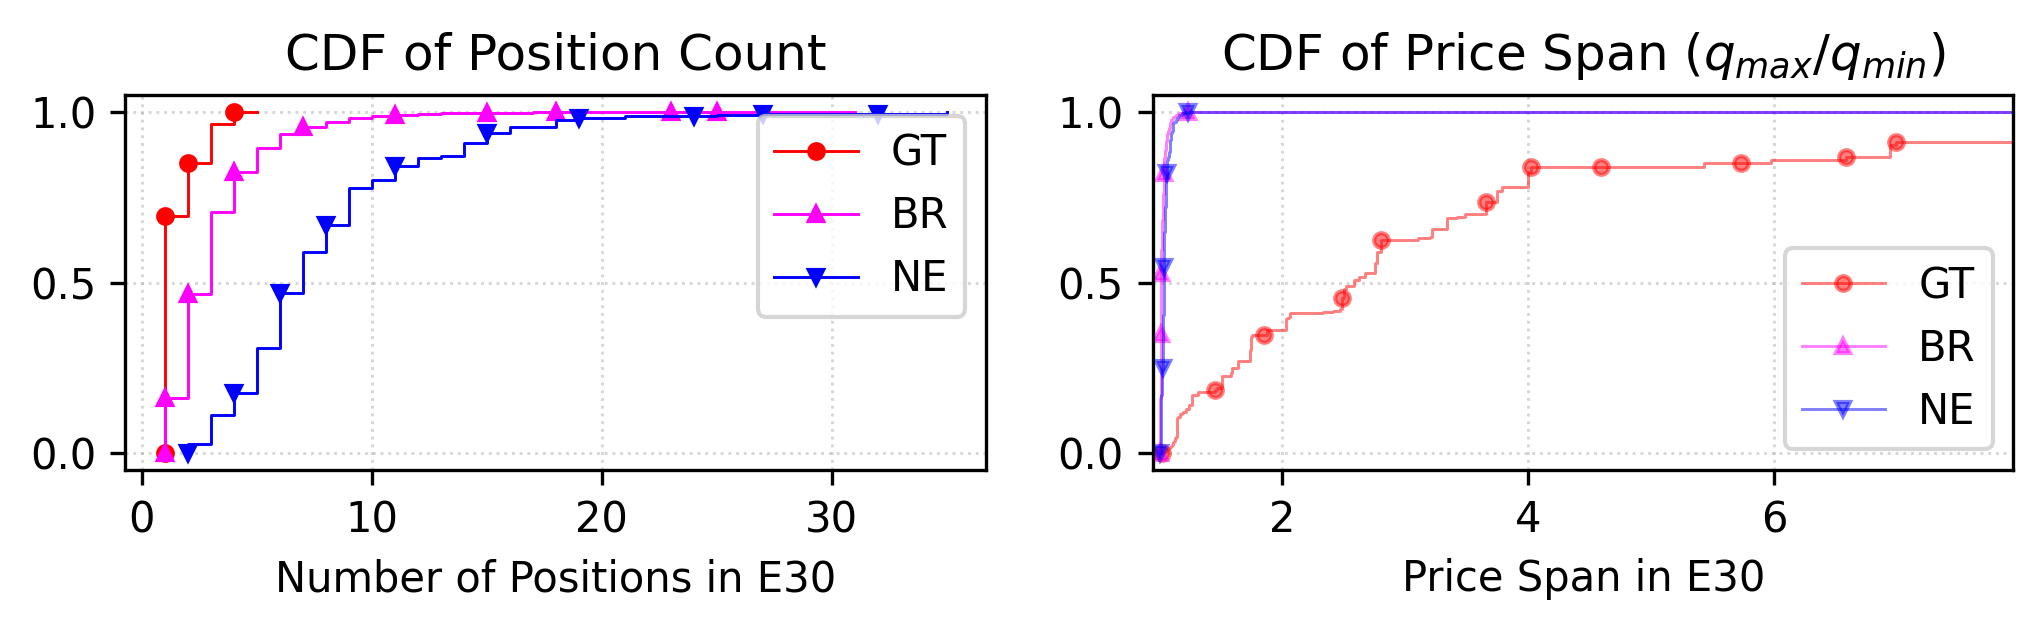

In [51]:
plot_price_span_count(2697600)

# 5. I-BR Tests (Utility/Overlap v.s. Expansion Factor R)

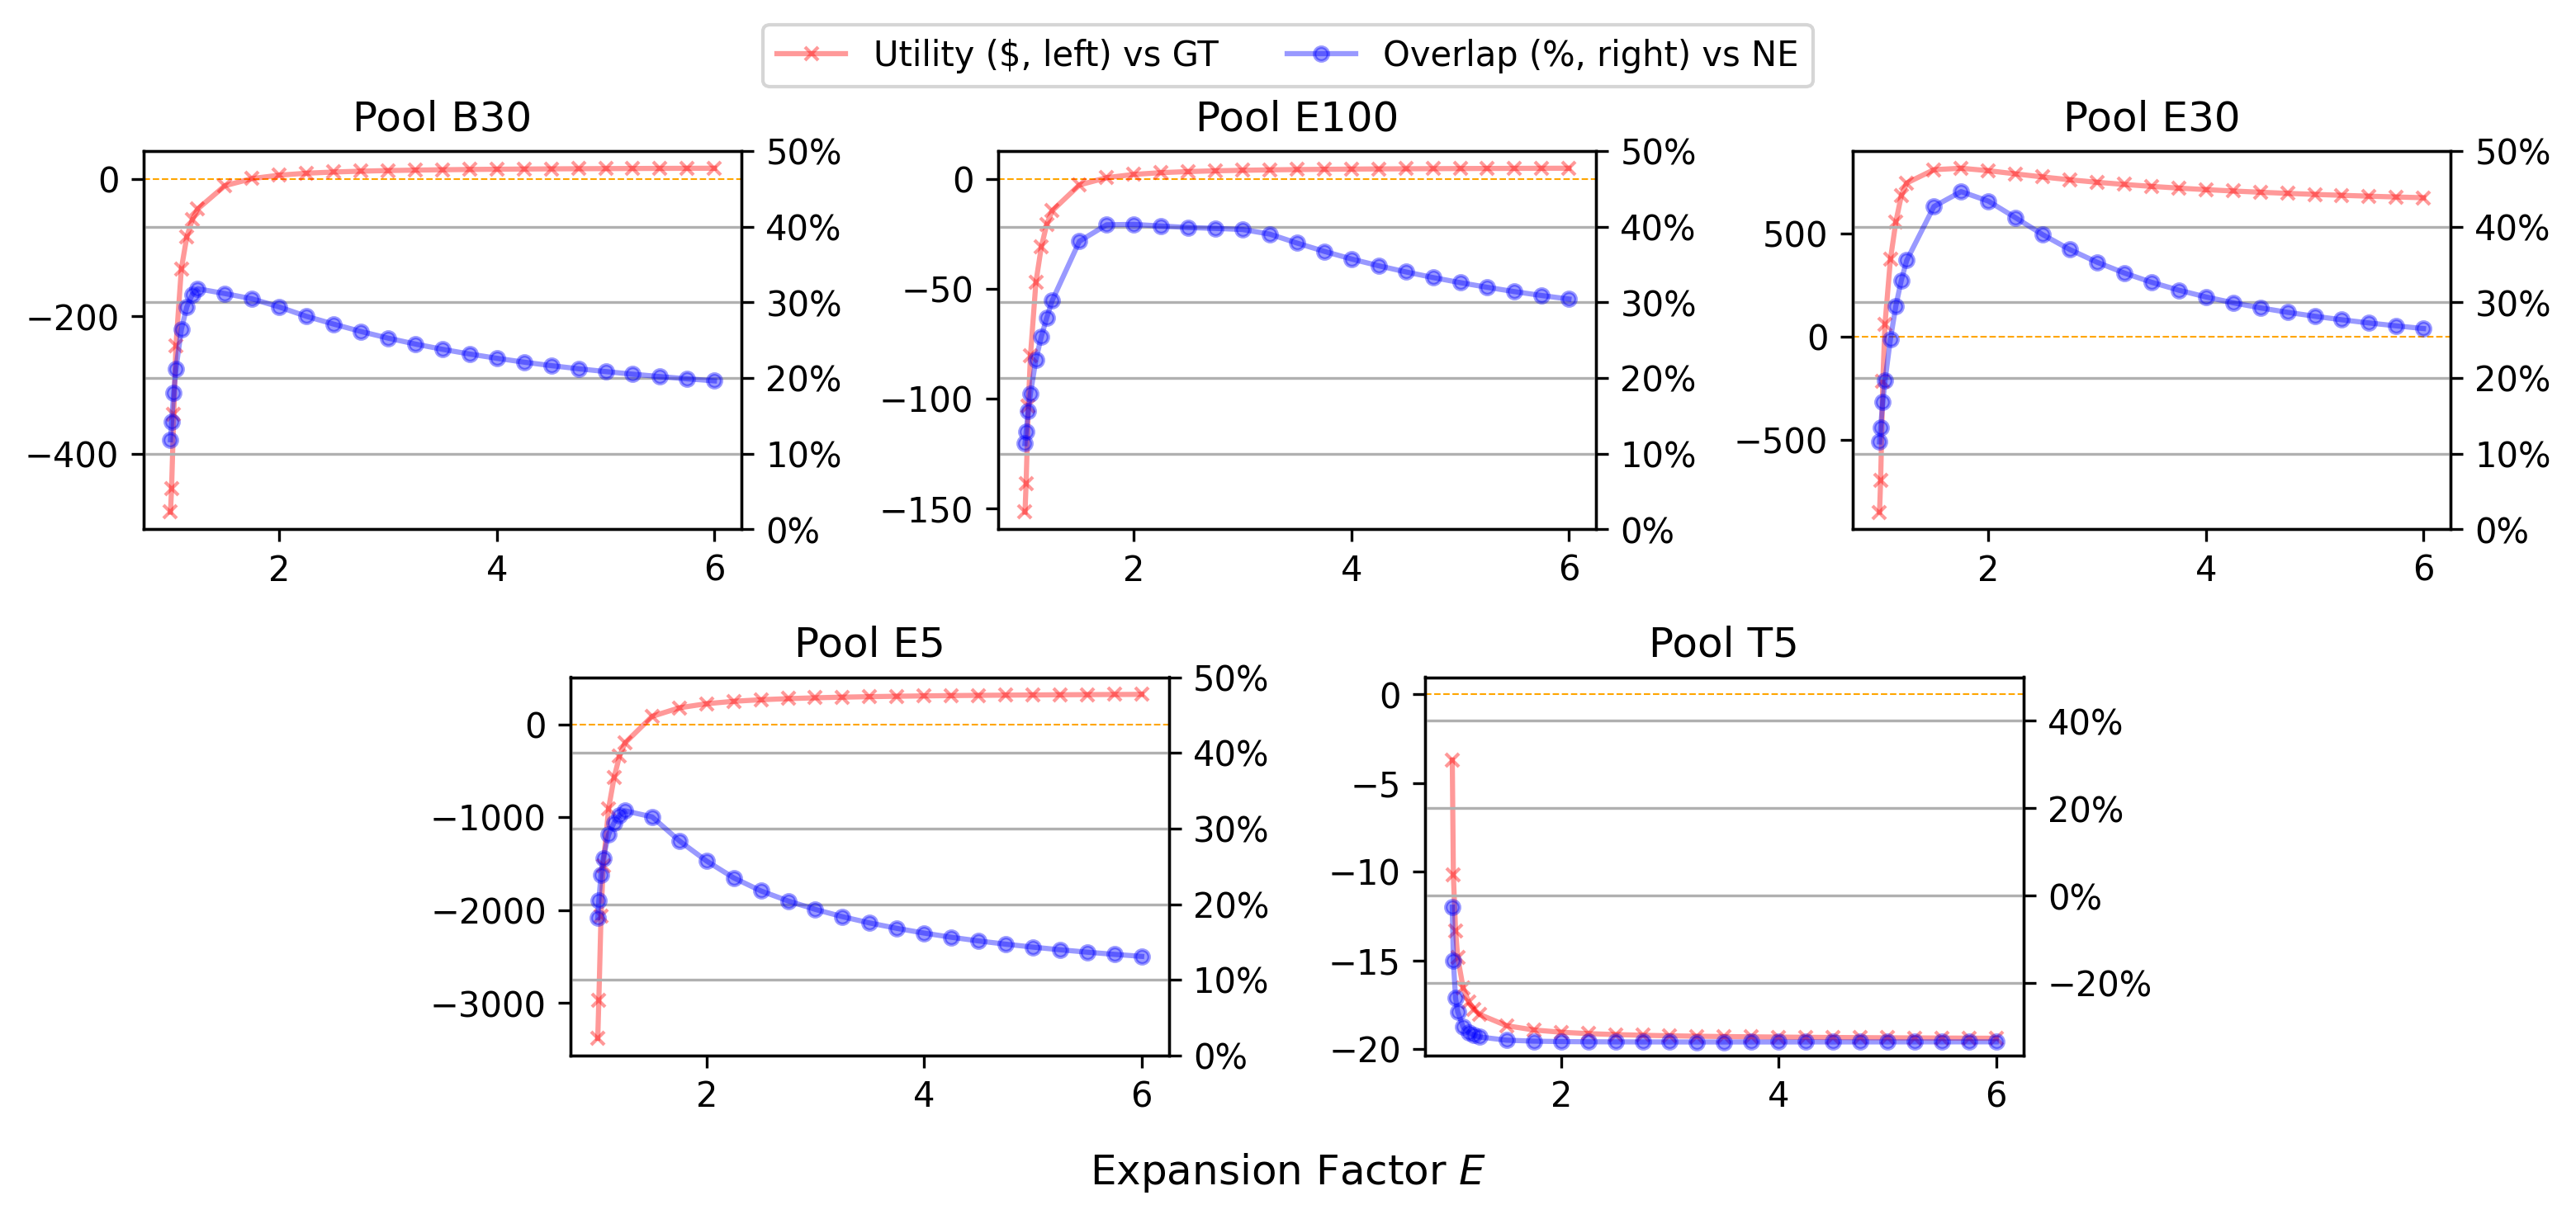

In [55]:
ids = [id for id in PIDS if os.path.exists(f'{ESSENCE_DATA}/I_BR-{id}.json')]
fig, axs = centered_subplots(nplots=len(ids), ncols=3, width=3.5, height=2.2)

for pid, ax in zip(ids, axs):
    with open(f'{ESSENCE_DATA}/I_BR-{pid}.pkl', 'rb') as f:
        obj = pickle.load(f)
    expansion, gt_util, ne_olap = np.array(obj['r']), np.array(obj['gt_utils']), np.array(obj['ne_olaps'])
    util_diff = [np.array(util) - gt_util for util in obj['utils']]
    olap_diff = [np.array(olap) - ne_olap for olap in obj['olaps']]
    udiff_avg, udiff_std = [np.mean(diff) for diff in util_diff], [np.std(diff) for diff in util_diff]
    odiff_avg, odiff_std = [np.mean(diff) for diff in olap_diff], [np.std(diff) for diff in olap_diff]
    ax.axhline(0, ls='--', color='orange', lw=.5)
    L1, = ax.plot(expansion, udiff_avg, marker='x', ms=4, alpha=.4, color='red', label='Utility ($, left) vs GT')

    ax = ax.twinx()
    L2, = ax.plot(expansion, odiff_avg, marker='o', ms=4, alpha=.4, color='blue', label='Overlap (%, right) vs NE')
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1., decimals=0))
    omin, omax = min(odiff_avg), max(odiff_avg)
    ax.set_ylim(min(0, omin - (omax-omin) * .1), max(.5, omax + (omax-omin) * .1))
    ax.grid(True)
    ax.set_title(f'Pool {NICK[pid]}')

xlab = fig.text(.5, 0, r'Expansion Factor $E$', ha='center', va='top', fontdict={'size': 12})
leg = fig.legend([L1, L2], [L.get_label() for L in [L1, L2]], loc='upper center', bbox_to_anchor=(.5, 1.05), ncols=2)
fig.tight_layout()
fig.savefig(f'{ESSENCE_DATA}/I_BR-test.jpg', bbox_inches='tight', bbox_extra_artists=[xlab, leg])
plt.show()
_ = gc.collect()